# Resolving the whole process of plant essential oil dataset
## Load the required packages

In [1]:
import pickle, os, sys, time
from pSCNN.db import get_spectra_sqlite, get_mz_ranges, rand_sub_sqlite1, \
                      convert_to_dense, plot_mz_hist, filter_spectra
from pSCNN.da import data_augmentation_1, data_augmentation_2
from pSCNN.snn import plot_loss_accuracy, check_pSCNN, build_pSCNN, load_pSCNN, \
                      predict_pSCNN, evaluate_pSCNN
from AutoRes.AutoRes import AutoRes, output_msp, AutoRes_alignment
import pandas as pd
from AutoRes.NetCDF import netcdf_reader  
import warnings
import wget
from zipfile import ZipFile

## Download plant essential oil dataset

In [2]:
url = "https://github.com/dyjfan/AutoRes/releases/download/1.0/data.zip"
save_path = wget.download(url, ".")
with ZipFile(save_path, 'r') as zip:
    zip.extractall(path = ".")
path = save_path[:-4]

100% [........................................................................] 58880810 / 58880810

## Load pSCNN1 model

In [3]:
mz_range = (1, 1000)
model_name1 = 'model/pSCNN1'
model_name2 = 'model/pSCNN2'
maxn1 = 1
maxn2 = 3

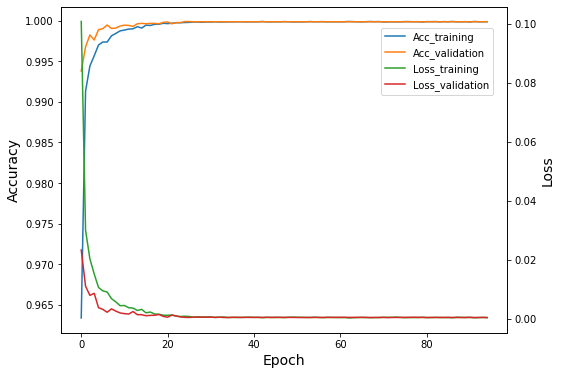

In [4]:
# pSCNN1 model
if check_pSCNN(model_name1):
        model1 = load_pSCNN(model_name1)
else:
    para = {'dbname': 'dataset/NIST_Spec0-236200.db',
            'mz_range': mz_range, 
            'aug_num': 200000,
            'noise_level': 0.001,
            'maxn': maxn1,
            'layer_num': 3,
            'batch': 200,
            'epoch': 200,
            'lr': 0.001,
            'factor':0.8,
            'min_lr':0.000002,
            'model_name': model_name1}
    model1 = build_pSCNN(para)
plot_loss_accuracy(model1)

## Load pSCNN2 model

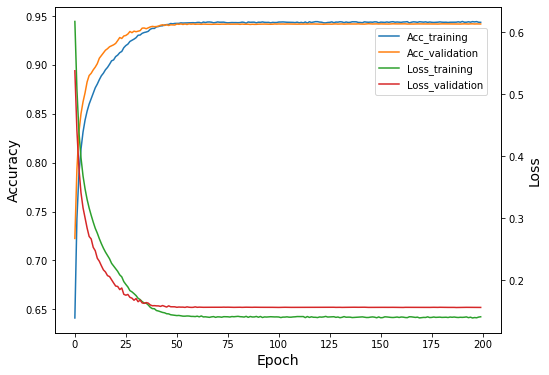

In [5]:
# pSCNN2 model
if check_pSCNN(model_name2):
    model2 = load_pSCNN(model_name2)
else:
    para = {'dbname': 'dataset/NIST_Spec0-236200.db',
            'mz_range': mz_range,
            'aug_num0': 100000,
            'aug_num1': 100000,
            'noise_level': 0.001,
            'maxn': maxn2,
            'layer_num': 2,
            'batch': 200,
            'epoch': 200,
            'lr': 0.0001,
            'factor':0.8,
            'min_lr':0.0000001,
            #'c':c,
            'model_name': model_name2}
    model2 = build_pSCNN(para)
plot_loss_accuracy(model2)

## AutoRes resolution of plant essential oil datasets

In [6]:
start = time.time()
files = os.listdir(path)
Alignment_or_not = True
if Alignment_or_not:
    df = AutoRes_alignment(path, files[0:5], model1, model2)
    df.to_csv(path + '/' + 'SetⅠ.csv', index=False)
    df = AutoRes_alignment(path, files[5:10], model1, model2)
    df.to_csv(path + '/' + 'SetⅡ.csv', index=False)
else:
    for filename in files:
        ncr = netcdf_reader(path + '/' + filename, True)
        sta_S, area, rt, R2 = AutoRes(ncr, model1, model2, filename)
        msp = filename.split('.CDF')[0] + '.MSP'
        output_msp(path + '/'+ msp, sta_S, rt)
        csv = filename.split('.CDF')[0] + '.csv'
        df = pd.DataFrame({'rt': rt, 'area': area, 'R2': R2})
        df.to_csv(path + '/' + csv, index = False)
end = time.time()
print("Running time: %.2fs"%(end - start))

2-1.0.CDF: 100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:42<00:00,  1.13s/it]

Running time: 366.12s
